In [17]:
%load_ext autoreload
%autoreload 2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(13)
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn import metrics
from scipy.io.arff import loadarff

# installable with: `pip install imodels`
from imodels import SLIMRegressor, BayesianRuleListClassifier, RuleFitRegressor, GreedyRuleListClassifier
from imodels import SLIMClassifier, OneRClassifier, BoostedRulesClassifier
from imodels.discretization import ExtraBasicDiscretizer

# change working directory to project root
if os.getcwd().split('/')[-1] != 'imodels':
    os.chdir('..')

def get_ames_data():
    housing = fetch_openml(name="house_prices", as_frame=True)
    housing_target = housing['target'].values
    housing_data_numeric = housing['data'].select_dtypes('number').drop(columns=['Id']).dropna(axis=1)
    feature_names = housing_data_numeric.columns.values
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
        housing_data_numeric.values, housing_target, test_size=0.75)
    return X_train_reg, X_test_reg, y_train_reg, y_test_reg, feature_names
    
def get_diabetes_data():
    '''load (classification) data on diabetes
    '''
    data = loadarff("tests/test_data/diabetes.arff")
    data_np = np.array(list(map(lambda x: np.array(list(x)), data[0])))
    X = data_np[:, :-1].astype('float32')
    y_text = data_np[:, -1].astype('str')
    y = (y_text == 'tested_positive').astype(int)  # labels 0-1
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75)  # split
    feature_names = ["#Pregnant", "Glucose concentration test", "Blood pressure(mmHg)",
                     "Triceps skin fold thickness(mm)",
                     "2-Hour serum insulin (mu U/ml)", "Body mass index", "Diabetes pedigree function", "Age (years)"]
    return X_train, X_test, y_train, y_test, feature_names

X_train_reg, X_test_reg, y_train_reg, y_test_reg, feat_names_reg = get_ames_data()
X_train, X_test, y_train, y_test, feat_names = get_diabetes_data()

def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    plt.subplot(121)
    plt.hist(probs[:, 1][y_test == 0], label='Class 0')
    plt.hist(probs[:, 1][y_test == 1], label='Class 1', alpha=0.8)
    plt.ylabel('Count')
    plt.xlabel('Predicted probability of class 1')
    plt.legend()

    plt.subplot(122)
    preds = np.argmax(probs, axis=1)
    plt.title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.plot(fpr, tpr)
    plt.tight_layout()
    plt.show()


# load some data
print('regression data', X_train_reg.shape, 'classification data', X_train.shape)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
regression data (365, 33) classification data (192, 8)


# rule sets
Rule sets are models that create a set of (potentially overlapping) rules.

### rulefit

In [15]:
# fit a rulefit model
rulefit = RuleFitRegressor(max_rules=10)
rulefit.fit(X_train_reg, y_train_reg, feature_names=feat_names_reg)

# get test performance
preds = rulefit.predict(X_test_reg)
print(f'test r2: {metrics.r2_score(y_test_reg, preds):0.2f}')

# inspect and print the rules
rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("support", ascending=False)

# 'rule' is how the feature is constructed
# 'coef' is its weight in the final linear model
# 'support' is the fraction of points it applies to
rules[['rule', 'coef', 'support']].style.background_gradient(cmap='viridis')

test r2: 0.63


,rule,coef,support
2,OverallQual,16444.208788,1.000000
9,TotalBsmtSF,0.299887,1.000000
13,GrLivArea,32.150210,1.000000
23,GarageArea,18.784050,1.000000
37,1stFlrSF <= 1417.0,-53.821871,0.731507
36,OverallQual <= 7.5 and TotalBsmtSF <= 1201.0,-9939.848976,0.641096
34,GrLivArea <= 1790.0 and YearBuilt <= 1994.5,-5774.881924,0.550685
35,GrLivArea <= 1789.5 and TotalBsmtSF <= 1199.5,-1774.730136,0.547945
33,GrLivArea <= 1928.5 and TotalBsmtSF <= 1089.0,-7556.897729,0.536986
38,1stFlrSF > 1417.0,0.000000,0.268493


## boosted stumps

In [ ]:
# fit boosted stumps
brc = BoostedRulesClassifier(n_estimators=10)
brc.fit(X_train, y_train, feature_names=feat_names)

print(brc)

# look at performance
probs = brc.predict_proba(X_test)
viz_classification_preds(probs, y_test)

# rule lists

### greedy rule lists
**like a decision tree that only ever splits going left**

In [ ]:
# fit a greedy rule list
m = GreedyRuleListClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = m.predict_proba(X_test)

# print the list
print(m)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

### oneR
**fits a rule list restricted to use only one feature**

In [ ]:
# fit a oneR model
m = OneRClassifier()
m.fit(X_train, y=y_train, feature_names=feat_names)  # stores into m.rules_
probs = m.predict_proba(X_test)

# print the rule list
print(m)

# look at prediction breakdown
viz_classification_preds(probs, y_test)

### scalable bayesian rule lists

In [18]:
disc = ExtraBasicDiscretizer(feat_names[:3], n_bins=3, strategy='uniform')
X_train_brl_df = disc.fit_transform(pd.DataFrame(X_train[:, :3], columns=feat_names[:3]))
X_test_brl_df = disc.transform(pd.DataFrame(X_test[:, :3], columns=feat_names[:3]))

training...
learned model:
 Trained RuleListClassifier 
IF Glucose concentration test_147.33333333333331_to_199.0 > 0.5 THEN probability of class 1: 65.9% (50.9%-79.4%)
ELSE IF Glucose concentration test_44.0_to_95.66666666666666 > 0.5 THEN probability of class 1: 11.1% (3.8%-21.7%)
ELSE IF #Pregnant_0.0_to_4.666666666666667 > 0.5 THEN probability of class 1: 22.9% (13.9%-33.3%)
ELSE probability of class 1: 47.7% (33.3%-62.3%)



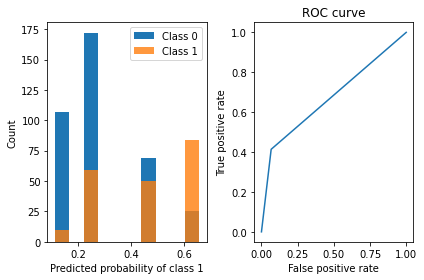

In [19]:
# train classifier (allow more iterations for better accuracy; use BigDataRuleListClassifier for large datasets)
print('training...')
m = BayesianRuleListClassifier()
m.fit(X_train_brl_df.values, y_train, feature_names=X_train_brl_df.columns)

probs = m.predict_proba(X_test_brl_df.values)
print("learned model:\n", m)
viz_classification_preds(probs, y_test)

# rule trees

### short decision tree

In [ ]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)

# calculate mse on the training data
probs = dt.predict_proba(X_test)
# print(f'test mse: {np.mean(np.square(preds-y)):0.2f}')

plot_tree(dt)
# plt.savefig('tree.pdf')
plt.show()

viz_classification_preds(probs, y_test)

### optimal classification tree
- docs [here](https://github.com/csinva/interpretability-workshop/tree/master/imodels/optimal_classification_tree)
- note: this implementation is still somewhat unstable, and can be made faster by installing either `cplex` or `gurobi`

In [ ]:
# sys.path.append('../imodels/optimal_classification_tree/pyoptree')
# sys.path.append('../imodels/optimal_classification_tree/')

In [ ]:
# from optree import OptimalTreeModel
# feature_names = np.array(["x1", "x2"])

# X = np.array([[1, 2, 2, 2, 3], [1, 2, 1, 0, 1]]).T
# y = np.array([1, 1, 0, 0, 0]).reshape(-1, 1)
# X_test = np.array([[1, 1, 2, 2, 2, 3, 3], [1, 2, 2, 1, 0, 1, 0]]).T
# y_test = np.array([1, 1, 1, 0, 0, 0, 0])

# np.random.seed(13)
# model = OptimalTreeModel(tree_depth=3, N_min=1, alpha=0.1) #, solver_name='baron'
# model.fit(X_test, y_test) # this method is currently using the fast, but not optimal solver
# preds = model.predict(X_test)

# # fit on the bigger diabetes dset from above
# # model.fit(Xtrain, ytrain) # this method is currently using the fast, but not optimal solver
# # preds = model.predict(Xtest)

# print('acc', np.mean(preds == y_test))

In [ ]:
# model.print_tree(feature_names)

# algebraic models

### integer linear models

In [ ]:
np.random.seed(123)

# generate X and y
n, p = 500, 10
X_sim = np.random.randn(n, p)
y_sim = 1 * X_sim[:, 0] + 2 * X_sim[:, 1] - 1 * X_sim[:, 2] + np.random.randn(n)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMRegressor()
for lambda_reg in [1e-3, 1e-2, 5e-2, 1e-1, 1, 2, 5, 10]:
    model.fit(X_sim, y_sim, lambda_reg)
    mse = np.mean(np.square(y_sim - model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmse: {mse: 0.2f}\tweights: {model.model_.coef_}')

In [ ]:
y_sim = 1 / (1 + np.exp(-y_sim))
y_sim = np.round(y_sim)

# fit linear models with different regularization parameters
print('groundtruth weights should be 1, 2, -1...')
model = SLIMClassifier()
for lambda_reg in [1e-3, 1e-2, 5e-2, 1e-1, 1, 2, 5, 10]:
    model.fit(X_sim, y_sim, lambda_reg)
    mll = np.mean(metrics.log_loss(y_sim, model.predict(X_sim)))
    print(f'lambda: {lambda_reg}\tmlogloss: {mll: 0.2f}\tweights: {model.model_.coef_}')